<a href="https://colab.research.google.com/github/Joaquin-Estevez/CAP4770/blob/main/Predicting_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries

In [42]:
!pip install matplotlib tensorflow pandas numpy keras

# Import Dependencies

In [59]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import cv2

# Load Data

In [46]:
import os
import kagglehub
from pathlib import Path

# Download and get the base path
base_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
base_path = Path(base_path) / 'chest_xray'

# Get Training Data

In [47]:
train_path = base_path / 'train'
PNEUMONIA_TRAIN_dir = train_path / 'PNEUMONIA'
NORMAL_TRAIN_dir = train_path / 'NORMAL'

pneumonia_train = os.listdir(PNEUMONIA_TRAIN_dir)
normal_train = os.listdir(NORMAL_TRAIN_dir)

print('There are', len(pneumonia_train), 'images of pneumonia infected in training dataset')
print('There are', len(normal_train), 'normal images in training dataset')

There are 3875 images of pneumonia infected in training dataset
There are 1341 normal images in training dataset


# Get Testing Data

In [48]:
test_path = base_path / 'test'
PNEUMONIA_TEST_dir = test_path / 'PNEUMONIA'
NORMAL_TEST_dir = test_path / 'NORMAL'

pneumonia_test = os.listdir(PNEUMONIA_TEST_dir)
normal_test = os.listdir(NORMAL_TEST_dir)

print('There are', len(pneumonia_test), 'images of pneumonia infected in testing dataset')
print('There are', len(normal_test), 'normal images in testing dataset')

There are 390 images of pneumonia infected in testing dataset
There are 234 normal images in testing dataset


# Get Validation Data

In [49]:
val_path = base_path / 'val'
PNEUMONIA_VAL_dir = val_path / 'PNEUMONIA'
NORMAL_VAL_dir = val_path / 'NORMAL'

pneumonia_val = os.listdir(PNEUMONIA_VAL_dir)
normal_val = os.listdir(NORMAL_VAL_dir)

print('There are', len(pneumonia_val), 'images of pneumonia infected in validation dataset')
print('There are', len(normal_val), 'normal images in validation dataset')

There are 8 images of pneumonia infected in validation dataset
There are 8 normal images in validation dataset


# Prepare Data for Testing, Test, and Validation before feeding

In [50]:
Train = keras.utils.image_dataset_from_directory(
    directory=str(base_path / 'train'),
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True)

Test = keras.utils.image_dataset_from_directory(
    directory=str(base_path / 'test'),
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True)

Validation = keras.utils.image_dataset_from_directory(
    directory=str(base_path / 'val'),
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


# Initialize Model

In [51]:
model = tf.keras.models.Sequential([
	layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
	layers.MaxPooling2D(2, 2),
	layers.Conv2D(64, (3, 3), activation='relu'),
	layers.MaxPooling2D(2, 2),
	layers.Conv2D(64, (3, 3), activation='relu'),
	layers.MaxPooling2D(2, 2),
	layers.Conv2D(64, (3, 3), activation='relu'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(512, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(512, activation='relu'),
	layers.Dropout(0.1),
	layers.BatchNormalization(),
	layers.Dense(512, activation='relu'),
	layers.Dropout(0.2),
	layers.BatchNormalization(),
	layers.Dense(512, activation='relu'),
	layers.Dropout(0.2),
	layers.BatchNormalization(),
	layers.Dense(2, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,0

 Total params: 7,313,474 (27.90 MB)

 Trainable params: 7,309,378 (27.88 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [53]:
model.compile(
	loss='binary_crossentropy',
	optimizer='adam',
	metrics=['accuracy']
)

# Training

In [54]:
history = model.fit(Train,
		epochs=1,
		validation_data=Validation)

163/163 ━━━━━━━━━━━━━━━━━━━━ 883s 5s/step - accuracy: 0.8862 - loss: 0.3093 - val_accuracy: 0.8750 - val_loss: 0.5029


In [55]:
model.save('model.h5')

# Evaluate Performance

In [56]:
loss, accuracy = model.evaluate(Test)
print('The accuracy of the model on test dataset is',
	np.round(accuracy*100))

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8528 - loss: 0.4128
The accuracy of the model on test dataset is 86.0


In [57]:
model.evaluate(Test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8731 - loss: 0.3880


[0.397095650434494, 0.8637820482254028]

# Analytics

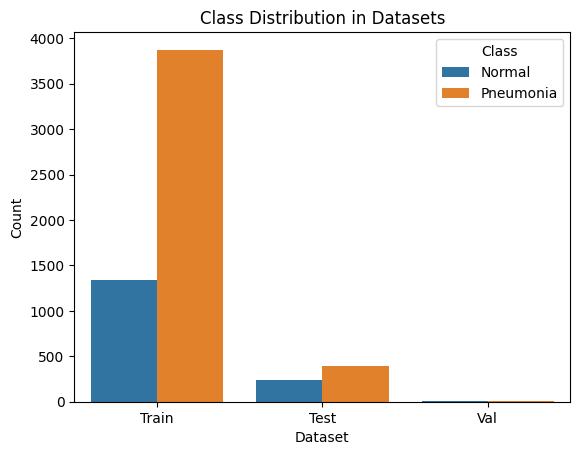

In [60]:
def plot_class_distribution():
    data = {
        "Dataset": ["Train", "Train", "Test", "Test", "Val", "Val"],
        "Class": ["Normal", "Pneumonia"] * 3,
        "Count": [len(normal_train), len(pneumonia_train),
                  len(normal_test), len(pneumonia_test),
                  len(normal_val), len(pneumonia_val)]
    }
    df = pd.DataFrame(data)
    sns.barplot(x="Dataset", y="Count", hue="Class", data=df)
    plt.title("Class Distribution in Datasets")
    plt.show()

plot_class_distribution()

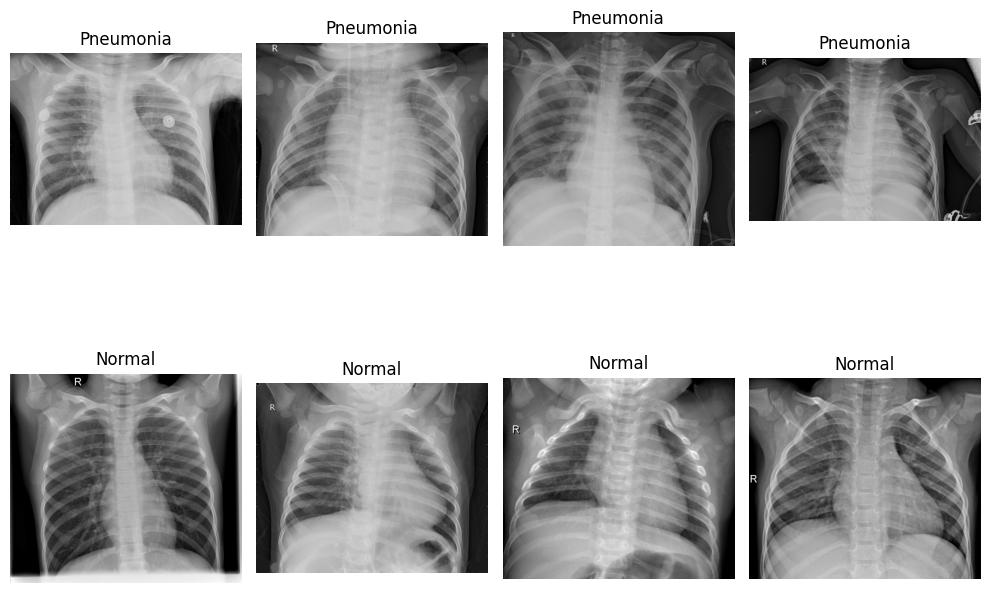

In [61]:
def plot_sample_images():
    plt.figure(figsize=(10, 8))
    for i, file_name in enumerate(os.listdir(PNEUMONIA_TRAIN_dir)[:4]):
        plt.subplot(2, 4, i + 1)
        img = mpimg.imread(PNEUMONIA_TRAIN_dir / file_name)
        plt.imshow(img, cmap='gray')
        plt.title("Pneumonia")
        plt.axis("off")

    for i, file_name in enumerate(os.listdir(NORMAL_TRAIN_dir)[:4]):
        plt.subplot(2, 4, i + 5)
        img = mpimg.imread(NORMAL_TRAIN_dir / file_name)
        plt.imshow(img, cmap='gray')
        plt.title("Normal")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_images()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


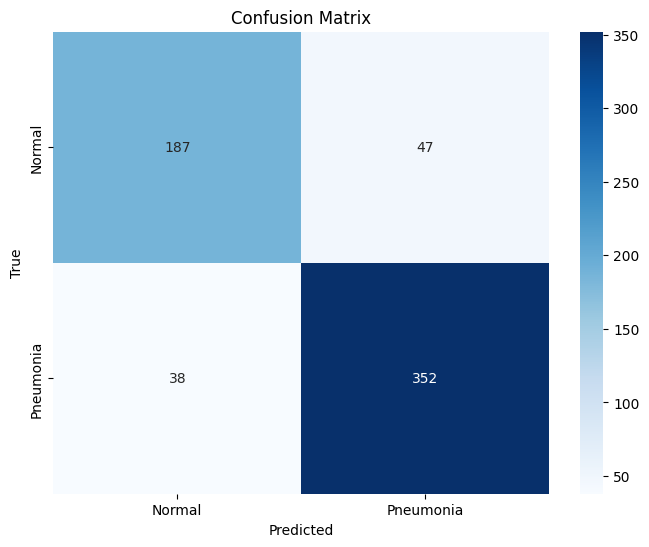

In [63]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

y_true = []
y_pred = []
for images, labels in Test:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

plot_confusion_matrix(y_true, y_pred, classes=["Normal", "Pneumonia"])

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

# Predict


Predicting Normal Case:


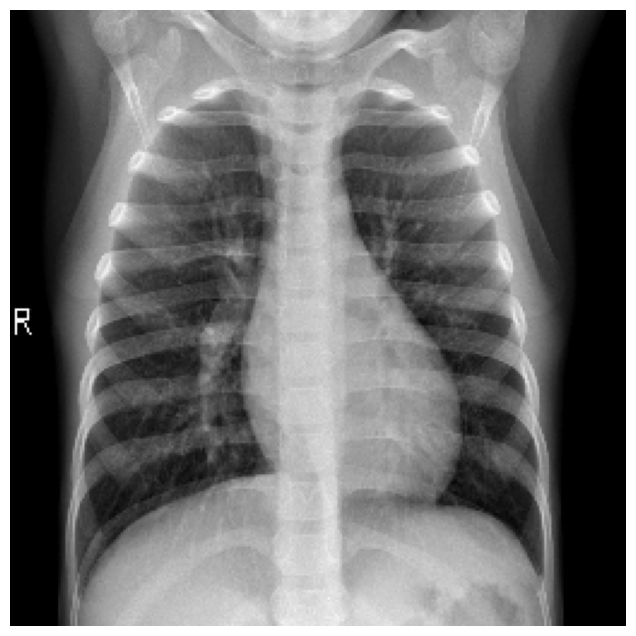

Prediction: Normal
Probability of Normal: 99.96%
Probability of Pneumonia: 1.40%

Predicting Pneumonia Case:


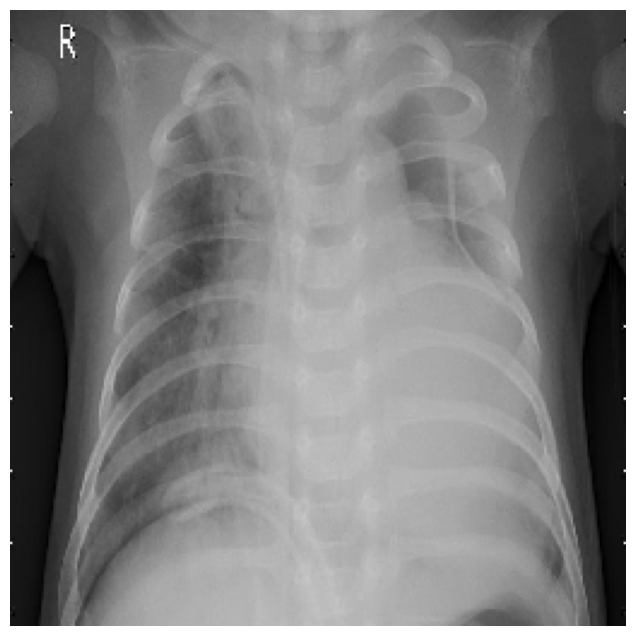

Prediction: Pneumonia
Probability of Normal: 3.71%
Probability of Pneumonia: 99.67%


In [70]:
def predict_xray(image_path, model):
    # Load the image
    test_image = tf.keras.utils.load_img(
        str(image_path),
        target_size=(256, 256)
    )

    # Display the loaded image
    plt.figure(figsize=(8, 8))
    plt.imshow(test_image)
    plt.axis('off')
    plt.show()

    # Convert image to array and prepare for prediction
    test_image = tf.keras.utils.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)

    # Make prediction
    result = model.predict(test_image, verbose=0)
    class_probabilities = result[0]

    # Print prediction and probabilities
    prediction = "Normal" if class_probabilities[0] > class_probabilities[1] else "Pneumonia"
    print(f"Prediction: {prediction}")
    print(f"Probability of Normal: {class_probabilities[0]:.2%}")
    print(f"Probability of Pneumonia: {class_probabilities[1]:.2%}")

# Test with a normal case
normal_image_path = base_path / 'test' / 'NORMAL' / 'NORMAL2-IM-0374-0001.jpeg'
print("\nPredicting Normal Case:")
predict_xray(normal_image_path, model)

# Test with a pneumonia case
pneumonia_image_path = base_path / 'test' / 'PNEUMONIA' / 'person111_bacteria_535.jpeg'
print("\nPredicting Pneumonia Case:")
predict_xray(pneumonia_image_path, model)